# Efficient-kan
From https://github.com/Blealtan/efficient-kan/tree/master

In [ ]:

import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

# MNIST

In [ ]:
# Train on MNIST
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Load MNIST
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
valset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

# Define model
model = KAN([28 * 28, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()
for epoch in range(10):
    # Train
    model.train()
    with tqdm(trainloader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            images = images.view(-1, 28 * 28).to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels.to(device))
            loss.backward()
            optimizer.step()
            accuracy = (output.argmax(dim=1) == labels.to(device)).float().mean()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.view(-1, 28 * 28).to(device)
            output = model(images)
            val_loss += criterion(output, labels.to(device)).item()
            val_accuracy += (
                (output.argmax(dim=1) == labels.to(device)).float().mean().item()
            )
    val_loss /= len(valloader)
    val_accuracy /= len(valloader)

    # Update learning rate
    scheduler.step()

    print(
        f"Epoch {epoch + 1}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}"
    )


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.59MB/s]
100%|██████████| 938/938 [00:17<00:00, 52.49it/s, accuracy=0.969, loss=0.271, lr=0.001]


Epoch 1, Val Loss: 0.22315161898257627, Val Accuracy: 0.9367038216560509


100%|██████████| 938/938 [00:17<00:00, 54.53it/s, accuracy=1, loss=0.0421, lr=0.0008]


Epoch 2, Val Loss: 0.1602950992780459, Val Accuracy: 0.9534235668789809


100%|██████████| 938/938 [00:17<00:00, 52.47it/s, accuracy=0.969, loss=0.0846, lr=0.00064]


Epoch 3, Val Loss: 0.1263044380603631, Val Accuracy: 0.9634753184713376


100%|██████████| 938/938 [00:16<00:00, 55.66it/s, accuracy=1, loss=0.0136, lr=0.000512]


Epoch 4, Val Loss: 0.11143254346932006, Val Accuracy: 0.9684514331210191


100%|██████████| 938/938 [00:17<00:00, 53.37it/s, accuracy=1, loss=0.0595, lr=0.00041]


Epoch 5, Val Loss: 0.10120893807067376, Val Accuracy: 0.9701433121019108


100%|██████████| 938/938 [00:17<00:00, 55.11it/s, accuracy=0.969, loss=0.0613, lr=0.000328]


Epoch 6, Val Loss: 0.09782401687216465, Val Accuracy: 0.9718351910828026


100%|██████████| 938/938 [00:17<00:00, 53.04it/s, accuracy=0.969, loss=0.0527, lr=0.000262]


Epoch 7, Val Loss: 0.09214880036087825, Val Accuracy: 0.9722332802547771


100%|██████████| 938/938 [00:17<00:00, 54.97it/s, accuracy=1, loss=0.0358, lr=0.00021]


Epoch 8, Val Loss: 0.09271731742384849, Val Accuracy: 0.973328025477707


100%|██████████| 938/938 [00:17<00:00, 54.78it/s, accuracy=0.969, loss=0.0517, lr=0.000168]


Epoch 9, Val Loss: 0.08936256368512549, Val Accuracy: 0.973328025477707


100%|██████████| 938/938 [00:17<00:00, 52.98it/s, accuracy=1, loss=0.0164, lr=0.000134]


Epoch 10, Val Loss: 0.08680303707002561, Val Accuracy: 0.9742237261146497


# Toy examples

Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 170.01it/s, train_loss=0.0722]


Epoch 30 — Val Loss: 0.1137


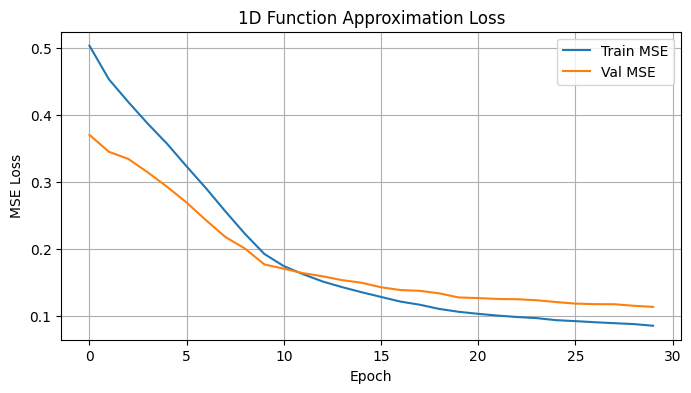

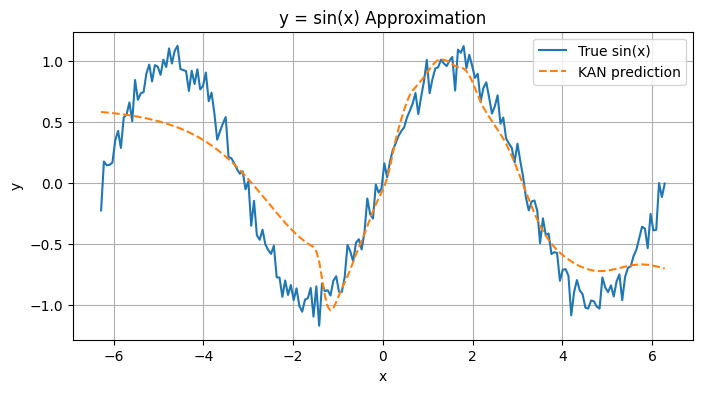

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# ————————————————————————————
# 1) Toy 1D dataset: y = sin(x) + noise
# ————————————————————————————
torch.manual_seed(0)
x_train = torch.linspace(-2*np.pi, 2*np.pi, 1000).unsqueeze(1)    # shape [1000,1]
y_train = torch.sin(x_train) + 0.1*torch.randn_like(x_train)      # shape [1000,1]

x_val = torch.linspace(-2*np.pi, 2*np.pi, 200).unsqueeze(1)
y_val = torch.sin(x_val) + 0.1*torch.randn_like(x_val)                                   # no noise

train_ds = torch.utils.data.TensorDataset(x_train, y_train)
val_ds   = torch.utils.data.TensorDataset(x_val,   y_val)

trainloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
valloader   = torch.utils.data.DataLoader(val_ds,   batch_size=64)

# ————————————————————————————
# 2) Model: use your KAN exactly as-is
#    (just change the dims list from [28*28,10] to [1,1])
# ————————————————————————————
# assume you have already defined/imported:
#     class KAN(nn.Module): ...
model = KAN([1, 10, 1], grid_size=10, spline_order=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ————————————————————————————
# 3) Loss, optimizer & scheduler
# ————————————————————————————
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses = []
val_losses   = []

# ————————————————————————————
# 4) Training & Validation loop
# ————————————————————————————
for epoch in range(30):
    # — Train —
    model.train()
    total_train_loss = 0.0
    with tqdm(trainloader, desc=f"Epoch {epoch+1:02d}") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)                   # -> shape [B,1]
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(train_loss=loss.item())
            total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(trainloader))

    # — Validate —
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            total_val_loss += criterion(preds, y_batch).item()
    avg_val_loss = total_val_loss / len(valloader)
    val_losses.append(avg_val_loss)

    scheduler.step()
print(f"Epoch {epoch+1:02d} — Val Loss: {avg_val_loss:.4f}")

# ————————————————————————————
# 5) Plot losses
# ————————————————————————————
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses,   label='Val MSE')
plt.title('1D Function Approximation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# ————————————————————————————
# 6) Compare prediction vs ground truth
# ————————————————————————————
model.eval()
with torch.no_grad():
    y_pred = model(x_val.to(device)).cpu()

plt.figure(figsize=(8,4))
plt.plot(x_val.numpy(), y_val.numpy(),    '-', label='True sin(x)')
plt.plot(x_val.numpy(), y_pred.numpy(), '--', label='KAN prediction')
plt.title('y = sin(x) Approximation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


Epoch 30: 100%|██████████| 16/16 [00:00<00:00, 347.46it/s, train_loss=0.321]


Epoch 30 — Val Loss: 0.3260


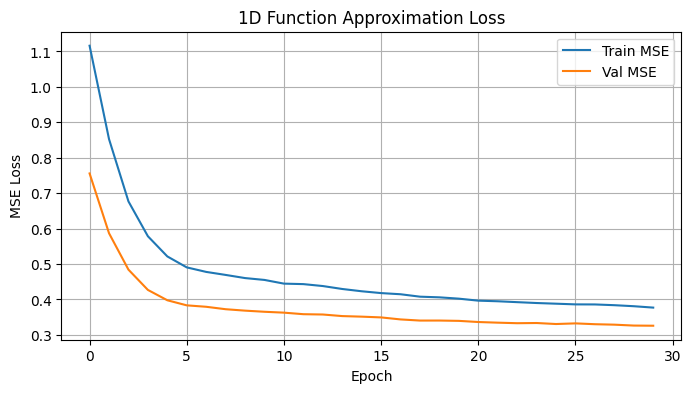

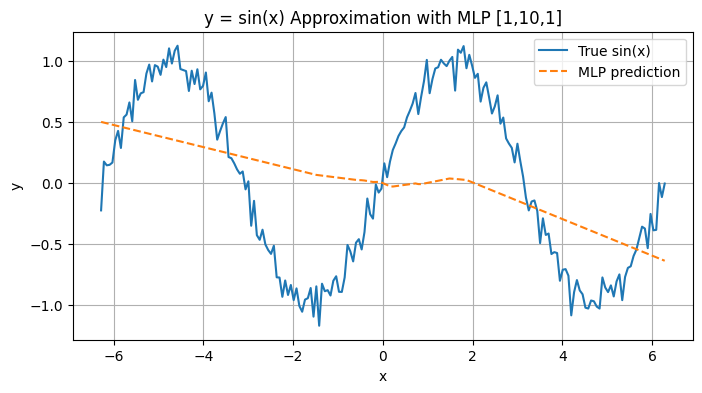

In [ ]:
# ————————————————————————————
# 2) Model: simple MLP [1 → 10 → 1]
# ————————————————————————————
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ————————————————————————————
# 3) Loss, optimizer & scheduler
# ————————————————————————————
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

train_losses = []
val_losses   = []

# ————————————————————————————
# 4) Training & Validation loop
# ————————————————————————————
for epoch in range(30):
    # — Train —
    model.train()
    total_train_loss = 0.0
    with tqdm(trainloader, desc=f"Epoch {epoch+1:02d}") as pbar:
        for x_batch, y_batch in pbar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            preds = model(x_batch)                   # -> [B,1]
            loss  = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            pbar.set_postfix(train_loss=loss.item())
            total_train_loss += loss.item()
    train_losses.append(total_train_loss / len(trainloader))

    # — Validate —
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in valloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch)
            total_val_loss += criterion(preds, y_batch).item()
    avg_val_loss = total_val_loss / len(valloader)
    val_losses.append(avg_val_loss)

    scheduler.step()
print(f"Epoch {epoch+1:02d} — Val Loss: {avg_val_loss:.4f}")

# ————————————————————————————
# 5) Plot losses
# ————————————————————————————
plt.figure(figsize=(8,4))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses,   label='Val MSE')
plt.title('1D Function Approximation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

# ————————————————————————————
# 6) Compare prediction vs ground truth
# ————————————————————————————
model.eval()
with torch.no_grad():
    y_pred = model(x_val.to(device)).cpu()

plt.figure(figsize=(8,4))
plt.plot(x_val.numpy(), y_val.numpy(),    '-', label='True sin(x)')
plt.plot(x_val.numpy(), y_pred.numpy(), '--', label='MLP prediction')
plt.title('y = sin(x) Approximation with MLP [1,10,1]')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Epoch 10 | MLP Val MSE: 2.0649 | KAN Val MSE: 1.5140
Epoch 20 | MLP Val MSE: 0.3386 | KAN Val MSE: 0.2676
Epoch 30 | MLP Val MSE: 0.2995 | KAN Val MSE: 0.2073
Epoch 40 | MLP Val MSE: 0.2933 | KAN Val MSE: 0.1865
Epoch 50 | MLP Val MSE: 0.2886 | KAN Val MSE: 0.1801


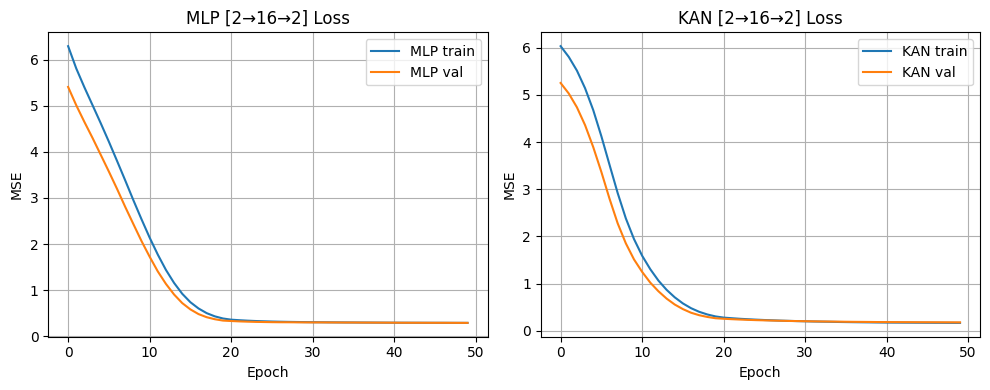

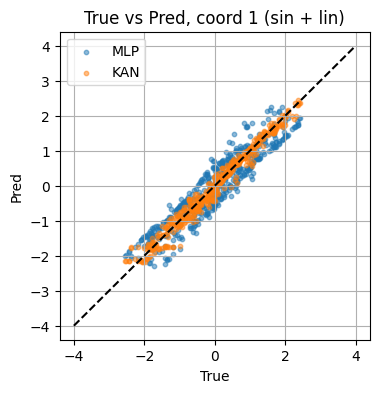

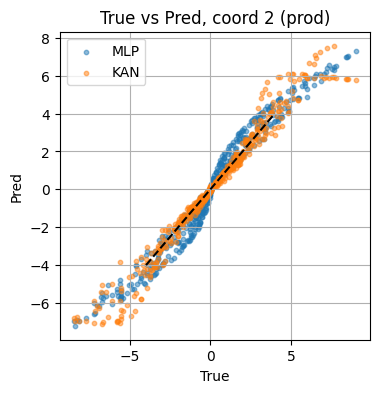

In [ ]:
# 1) Synthetic 2D regression problem
np.random.seed(0)
N_train, N_val = 2000, 500

X = np.random.uniform(-np.pi, np.pi, size=(N_train+N_val, 2))
Y = np.stack([
    np.sin(X[:,0]) + 0.5*X[:,1],
    X[:,0] * X[:,1]
], axis=1)

X_train, Y_train = X[:N_train], Y[:N_train]
X_val,   Y_val   = X[N_train:], Y[N_train:]

train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(Y_train).float())
val_ds   = TensorDataset(torch.from_numpy(X_val).float(),
                         torch.from_numpy(Y_val).float())

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)

# 2) Models: KAN vs. MLP
# — MLP [2 → 16 → 2]
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
        )
    def forward(self, x):
        return self.net(x)

# — KAN [2 → 16 → 2]

model_mlp = MLP()
model_kan = KAN([2, 16, 2])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp.to(device)
model_kan.to(device)

# 3) Training setup
criterion = nn.MSELoss()
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
opt_kan = optim.Adam(model_kan.parameters(), lr=1e-3)
sched_mlp = optim.lr_scheduler.StepLR(opt_mlp, step_size=20, gamma=0.5)
sched_kan = optim.lr_scheduler.StepLR(opt_kan, step_size=20, gamma=0.5)

def train_epoch(model, opt, loader):
    model.train()
    total = 0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        total += loss.item() * x.size(0)
    return total / len(loader.dataset)

def eval_epoch(model, loader):
    model.eval()
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            total += criterion(model(x), y).item() * x.size(0)
    return total / len(loader.dataset)

# 4) Train both
epochs = 50
hist = {"mlp_train":[], "mlp_val":[], "kan_train":[], "kan_val":[]}

for ep in range(epochs):
    hist["mlp_train"].append(train_epoch(model_mlp, opt_mlp, train_loader))
    hist["mlp_val"].append(  eval_epoch(model_mlp,             val_loader))
    sched_mlp.step()

    hist["kan_train"].append(train_epoch(model_kan, opt_kan, train_loader))
    hist["kan_val"].append(  eval_epoch(model_kan,             val_loader))
    sched_kan.step()

    if (ep+1)%10==0:
        print(f"Epoch {ep+1:02d} | MLP Val MSE: {hist['mlp_val'][-1]:.4f} | KAN Val MSE: {hist['kan_val'][-1]:.4f}")

# 5) Plot Loss Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(hist["mlp_train"], label="MLP train")
plt.plot(hist["mlp_val"],   label="MLP val")
plt.title("MLP [2→16→2] Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(hist["kan_train"], label="KAN train")
plt.plot(hist["kan_val"],   label="KAN val")
plt.title("KAN [2→16→2] Loss"); plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

# 6) Scatter: True vs. Predicted (Validation set)
Xv = torch.from_numpy(X_val).float().to(device)
Yv = torch.from_numpy(Y_val).float().to(device)
with torch.no_grad():
    Y_mlp = model_mlp(Xv).cpu().numpy()
    Y_kan = model_kan(Xv).cpu().numpy()

for i,name in enumerate(["(sin + lin)", "(prod)"]):
    plt.figure(figsize=(4,4))
    plt.scatter(Y_val[:,i], Y_mlp[:,i], s=10, alpha=0.5, label="MLP")
    plt.scatter(Y_val[:,i], Y_kan[:,i], s=10, alpha=0.5, label="KAN")
    plt.plot([-4,4],[-4,4], 'k--')
    plt.title(f"True vs Pred, coord {i+1} {name}")
    plt.xlabel("True"); plt.ylabel("Pred")
    plt.legend(); plt.grid(True)
    plt.show()


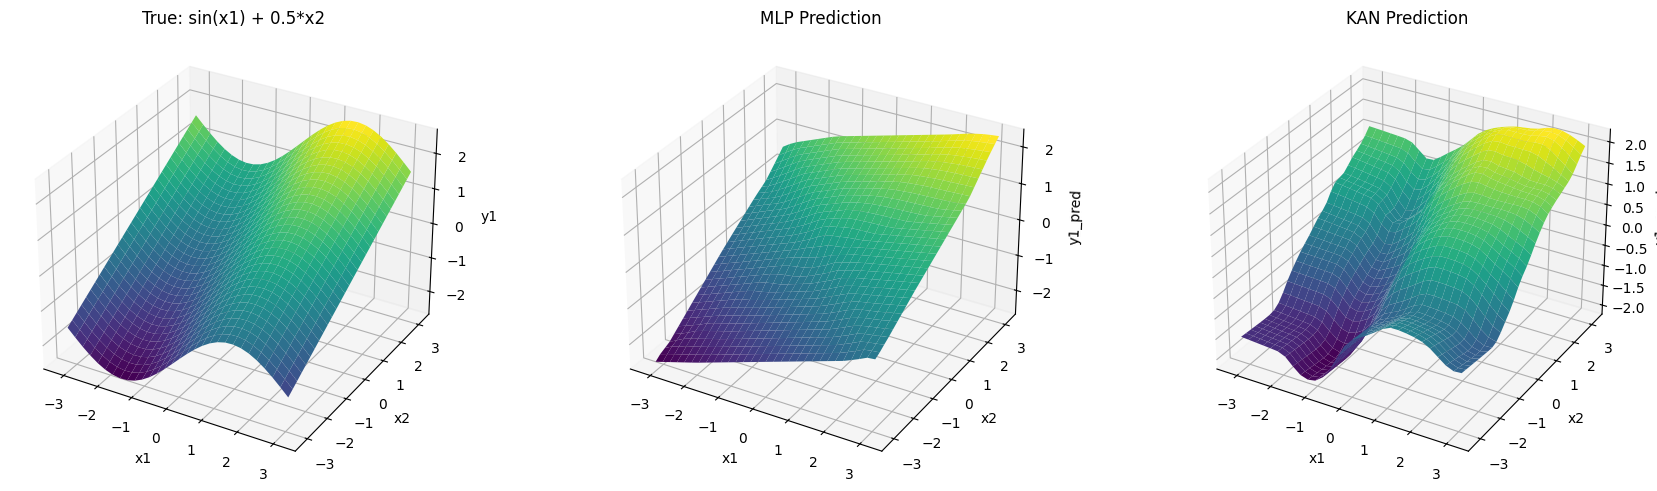

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# 1) Synthetic 2D regression problem
np.random.seed(0)
N_train, N_val = 1000, 200
X = np.random.uniform(-np.pi, np.pi, size=(N_train+N_val, 2))
Y = np.stack([
    np.sin(X[:,0]) + 0.5 * X[:,1],
    X[:,0] * X[:,1]
], axis=1)
X_train, Y_train = X[:N_train], Y[:N_train]
X_val, Y_val = X[N_train:], Y[N_train:]

train_ds = TensorDataset(torch.from_numpy(X_train).float(),
                         torch.from_numpy(Y_train).float())
val_ds = TensorDataset(torch.from_numpy(X_val).float(),
                       torch.from_numpy(Y_val).float())

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# 2) Models: MLP and KAN
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16), nn.ReLU(),
            nn.Linear(16, 2)
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP()
model_kan = KAN([2, 16, 2])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp.to(device)
model_kan.to(device)

# 3) Train both models
criterion = nn.MSELoss()
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
opt_kan = optim.Adam(model_kan.parameters(), lr=1e-3)

def train(model, opt):
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        opt.step()

# Quick training loop
for epoch in range(30):
    train(model_mlp, opt_mlp)
    train(model_kan, opt_kan)

# 4) Create a grid for 3D surface plot
grid_size = 30
x1 = np.linspace(-np.pi, np.pi, grid_size)
x2 = np.linspace(-np.pi, np.pi, grid_size)
X1, X2 = np.meshgrid(x1, x2)
XY = np.stack([X1.ravel(), X2.ravel()], axis=1)
XY_t = torch.from_numpy(XY).float().to(device)

# True surface for first target coordinate
Z_true_1 = (np.sin(X1) + 0.5 * X2)

# Predictions
with torch.no_grad():
    preds_mlp = model_mlp(XY_t).cpu().numpy()[:, 0].reshape(grid_size, grid_size)
    preds_kan = model_kan(XY_t).cpu().numpy()[:, 0].reshape(grid_size, grid_size)

# 5) Plotting
fig = plt.figure(figsize=(18, 5))

# True surface
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(X1, X2, Z_true_1, cmap='viridis', edgecolor='none')
ax1.set_title('True: sin(x1) + 0.5*x2')
ax1.set_xlabel('x1'); ax1.set_ylabel('x2'); ax1.set_zlabel('y1')

# MLP prediction
ax2 = fig.add_subplot(132, projection='3d')
ax2.plot_surface(X1, X2, preds_mlp, cmap='viridis', edgecolor='none')
ax2.set_title('MLP Prediction')
ax2.set_xlabel('x1'); ax2.set_ylabel('x2'); ax2.set_zlabel('y1_pred')

# KAN prediction
ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(X1, X2, preds_kan, cmap='viridis', edgecolor='none')
ax3.set_title('KAN Prediction')
ax3.set_xlabel('x1'); ax3.set_ylabel('x2'); ax3.set_zlabel('y1_pred')

plt.tight_layout()
plt.show()

Epoch 020 | MLP val MSE: 0.2770 | KAN val MSE: 0.1431
Epoch 040 | MLP val MSE: 0.1816 | KAN val MSE: 0.0434
Epoch 060 | MLP val MSE: 0.1245 | KAN val MSE: 0.0342
Epoch 080 | MLP val MSE: 0.0953 | KAN val MSE: 0.0297
Epoch 100 | MLP val MSE: 0.0773 | KAN val MSE: 0.0263


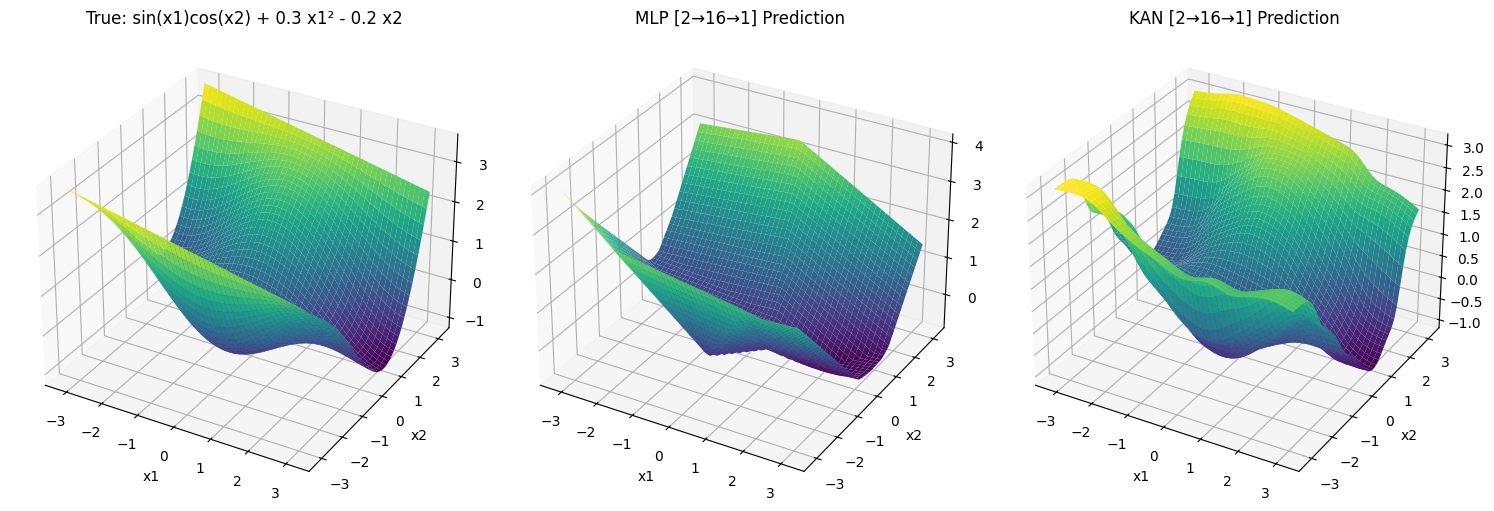

In [ ]:
# 1) Build dataset
np.random.seed(0)
N_train, N_val = 2000, 500

# Uniform sample in [-π,π]^2
X = np.random.uniform(-np.pi, np.pi, size=(N_train+N_val, 2))

# Complex target: sin(x1)·cos(x2) + 0.3 x1^2 - 0.2 x2 + noise
Y_clean = (
    np.sin(X[:,0]) * np.cos(X[:,1])
    + 0.3 * X[:,0]**2
    - 0.2 * X[:,1]
)
Y = Y_clean + 0.05 * np.random.randn(N_train+N_val)

# Split
X_train, Y_train = X[:N_train], Y[:N_train]
X_val,   Y_val   = X[N_train:], Y[N_train:]

train_ds = TensorDataset(
    torch.from_numpy(X_train).float(),
    torch.from_numpy(Y_train).unsqueeze(1).float()
)
val_ds = TensorDataset(
    torch.from_numpy(X_val).float(),
    torch.from_numpy(Y_val).unsqueeze(1).float()
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=64)


# 2) Define models
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
        )
    def forward(self, x):
        return self.net(x)

model_mlp = MLP()
model_kan = KAN([2, 10, 1], grid_size = 3, scale_spline=0.05)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mlp.to(device)
model_kan.to(device)


# 3) Training setup
criterion = nn.MSELoss()
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-3)
opt_kan = optim.Adam(model_kan.parameters(), lr=1e-3)
sched_mlp = optim.lr_scheduler.StepLR(opt_mlp, step_size=50, gamma=0.5)
sched_kan = optim.lr_scheduler.StepLR(opt_kan, step_size=50, gamma=0.5)

def train_one_epoch(model, opt, loader):
    model.train()
    total_loss = 0.0
    for x,y in loader:
        x,y = x.to(device), y.to(device)
        opt.zero_grad()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

def eval_mse(model, loader):
    model.eval()
    total = 0.0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(device), y.to(device)
            total += criterion(model(x), y).item() * x.size(0)
    return total / len(loader.dataset)

# 4) Train
epochs = 100
for epoch in range(1, epochs+1):
    train_one_epoch(model_mlp, opt_mlp, train_loader)
    train_one_epoch(model_kan, opt_kan, train_loader)
    sched_mlp.step()
    sched_kan.step()
    if epoch % 20 == 0:
        mse_mlp = eval_mse(model_mlp, val_loader)
        mse_kan = eval_mse(model_kan, val_loader)
        print(f"Epoch {epoch:03d} | MLP val MSE: {mse_mlp:.4f} | KAN val MSE: {mse_kan:.4f}")


# 5) Build a grid for 3D plotting
grid = 50
x1 = np.linspace(-np.pi, np.pi, grid)
x2 = np.linspace(-np.pi, np.pi, grid)
X1, X2 = np.meshgrid(x1, x2)
XY = np.stack([X1.ravel(), X2.ravel()], axis=1)
XY_t = torch.from_numpy(XY).float().to(device)

# True surface (clean, without noise)
Z_true = (
    np.sin(X1) * np.cos(X2)
    + 0.3 * X1**2
    - 0.2 * X2
)

# Model predictions
with torch.no_grad():
    Z_mlp = model_mlp(XY_t).cpu().numpy().reshape(grid, grid)
    Z_kan = model_kan(XY_t).cpu().numpy().reshape(grid, grid)


# 6) 3D plots
fig = plt.figure(figsize=(15, 5))

# True surface
ax = fig.add_subplot(131, projection='3d')
ax.plot_surface(X2, X1, Z_true, cmap='viridis', edgecolor='none')
ax.set_title('True: sin(x1)cos(x2) + 0.3 x1² - 0.2 x2')
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('y')

# MLP fit
ax = fig.add_subplot(132, projection='3d')
ax.plot_surface(X2, X1, Z_mlp, cmap='viridis', edgecolor='none')
ax.set_title('MLP [2→16→1] Prediction')
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('ŷ')

# KAN fit
ax = fig.add_subplot(133, projection='3d')
ax.plot_surface(X2, X1, Z_kan, cmap='viridis', edgecolor='none')
ax.set_title('KAN [2→16→1] Prediction')
ax.set_xlabel('x1'); ax.set_ylabel('x2'); ax.set_zlabel('ŷ')

plt.tight_layout()
plt.show()
